## Student Registration Number : 2007253
## Project : seq2seq translation

In [57]:
# Import relevant packages
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow import keras
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
from nltk import pos_tag
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data Exploration

In [58]:
# Import dataset from the train_spider.json
df1 = pd.read_json('/content/drive/MyDrive/CE888/train_spider.json')

In [59]:
# View the dataset
df1.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


In [60]:
# Some insights about the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   db_id                7000 non-null   object
 1   query                7000 non-null   object
 2   query_toks           7000 non-null   object
 3   query_toks_no_value  7000 non-null   object
 4   question             7000 non-null   object
 5   question_toks        7000 non-null   object
 6   sql                  7000 non-null   object
dtypes: object(7)
memory usage: 382.9+ KB


In [61]:
# Some more insights about the dataset
df1.describe()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
count,7000,7000,7000,7000,7000,7000,7000
unique,140,3964,3962,3886,6962,6962,3580
top,college_2,SELECT count(*) FROM Accounts,"[SELECT, count, (, *, ), FROM, Accounts]","[select, count, (, *, ), from, customers]",How many students are there?,"[How, many, students, are, there, ?]","{'from': {'table_units': [['table_unit', 0]], ..."
freq,170,6,6,13,4,4,89


In [62]:
# Import dataset from the train_others.json
df2 = pd.read_json('/content/drive/MyDrive/CE888/train_others.json')

In [63]:
# View the dataset
df2.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what is the biggest city in wyoming,"[what, is, the, biggest, city, in, wyoming]","{'from': {'table_units': [['table_unit', 1]], ..."
1,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what wyoming city has the largest population,"[what, wyoming, city, has, the, largest, popul...","{'from': {'table_units': [['table_unit', 1]], ..."
2,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what is the largest city in wyoming,"[what, is, the, largest, city, in, wyoming]","{'from': {'table_units': [['table_unit', 1]], ..."
3,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",where is the most populated area of wyoming,"[where, is, the, most, populated, area, of, wy...","{'from': {'table_units': [['table_unit', 1]], ..."
4,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",which city in wyoming has the largest population,"[which, city, in, wyoming, has, the, largest, ...","{'from': {'table_units': [['table_unit', 1]], ..."


In [64]:
# Some insights about the dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   db_id                1659 non-null   object
 1   query                1659 non-null   object
 2   query_toks           1659 non-null   object
 3   query_toks_no_value  1659 non-null   object
 4   question             1659 non-null   object
 5   question_toks        1659 non-null   object
 6   sql                  1659 non-null   object
dtypes: object(7)
memory usage: 90.9+ KB


In [65]:
# Some more insights about the dataset
df2.describe()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
count,1659,1659,1659,1659,1659,1659,1659
unique,6,750,750,743,1659,1659,750
top,scholar,"SELECT t2.house_number , t1.name FROM restau...","[SELECT, t2.house_number, ,, t1.name, FROM, re...","[select, distinct, t3, ., paperid, from, paper...",what is the biggest city in wyoming,"[what, is, the, biggest, city, in, wyoming]","{'from': {'table_units': [['table_unit', 1], [..."
freq,569,23,23,26,1,1,23


In [66]:
# Combining the two dataframes
frames = [df1, df2]
  
df_combined = pd.concat(frames,ignore_index=True)
df_combined.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


##### The input dataset already has tokenized versions of SQL queries and the questions
##### We will use these two columns for further processing by creating a new dataframe

In [67]:
df_use=df_combined[['question_toks','query',]].copy(deep=True)

# Check the new dataframe
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8659 entries, 0 to 8658
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_toks  8659 non-null   object
 1   query          8659 non-null   object
dtypes: object(2)
memory usage: 135.4+ KB


In [68]:
# Analyse words in 'question_toks' column
input_words = []

for i in range (len(df_use)):
  input_word=df_use.loc[i, "question_toks"]
  input_words.append(input_word)

In [69]:
# Convert the list of list as a single list
all_input_words = [item for sublist in input_words for item in sublist]
print("Number of words:", len(all_input_words))

Number of words: 114582


In [70]:
# Finding the top 50 words with highest freqency
input_words_frequency = FreqDist(all_input_words)
common_25=(input_words_frequency.most_common(25))
print(common_25)

[('the', 11179), ('of', 5797), ('?', 4383), ('.', 3558), ('What', 2672), ('are', 2669), ('and', 2619), ('in', 2541), ('is', 1877), ('names', 1554), ('name', 1546), ('all', 1405), ('with', 1345), ('that', 1332), ('number', 1292), ('have', 1244), ('``', 1229), ('Find', 1162), (',', 1046), ('for', 1022), ('many', 1013), ('who', 954), ('How', 816), ('by', 781), ('Show', 769)]


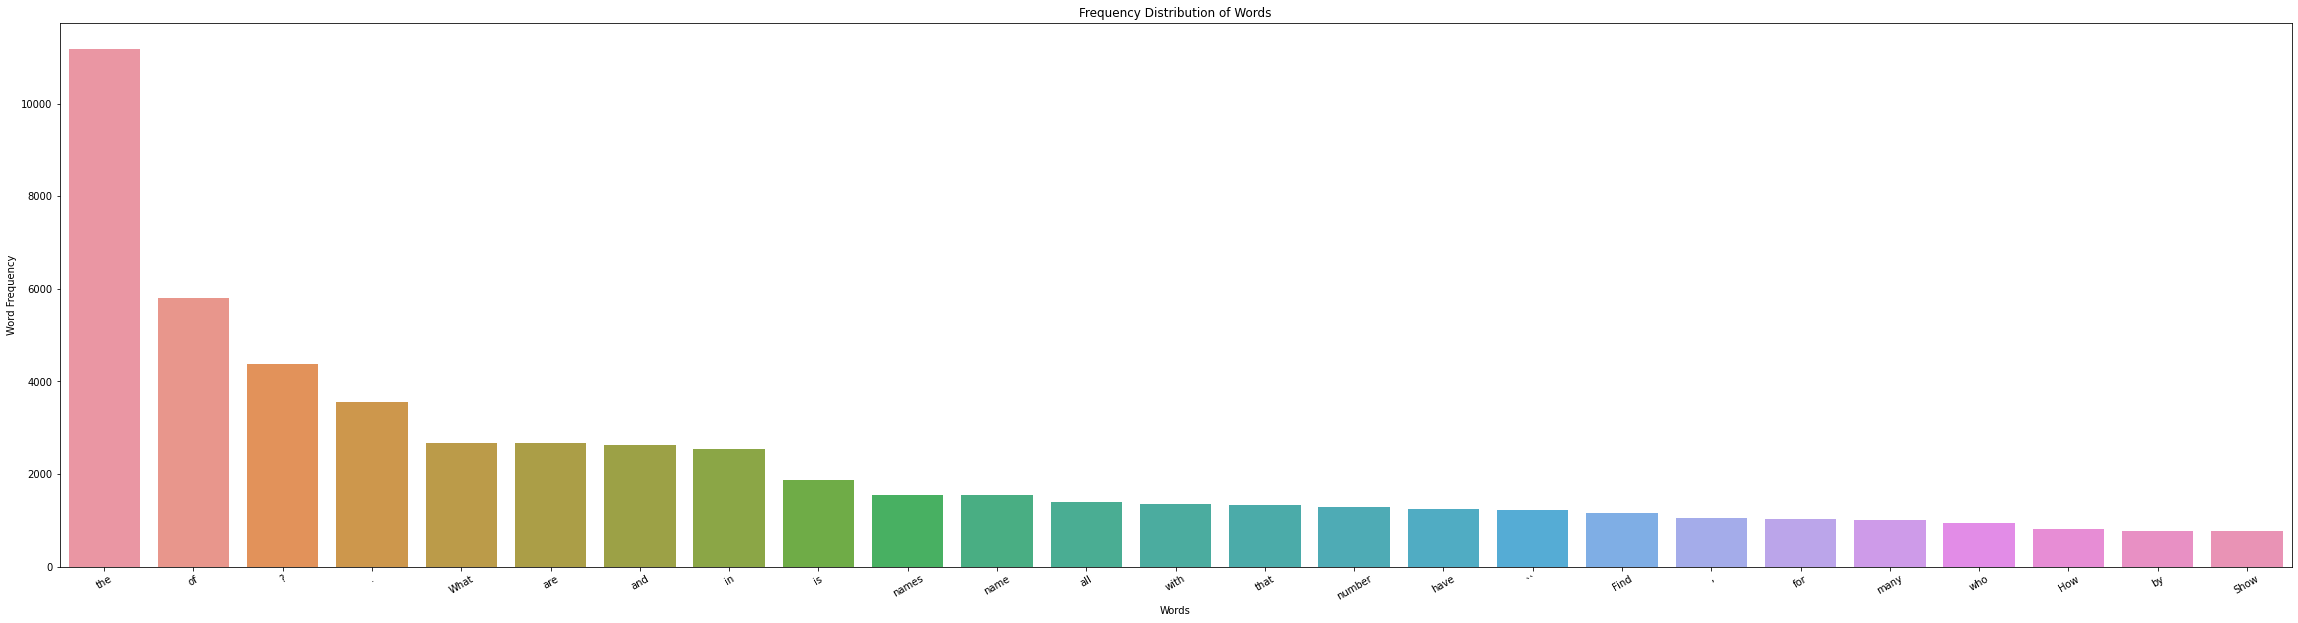

In [71]:
# Conversion to Pandas series via Python Dictionary for easier plotting
input_words_fdist = pd.Series(dict(common_25))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(40,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
plt.title('Frequency Distribution of Words')
plt.xlabel("Words")
plt.ylabel("Word Frequency")
all_plot = sns.barplot(x=input_words_fdist.index, y=input_words_fdist.values, ax=ax)
plt.xticks(rotation=30);
plt.savefig('before.pdf',dpi=1200)

##### From the above frequency distribution plot it is evident that stop words like 'the', 'of', 'in', 'is' have the highest occurances. Removing them from 'question_toks' column will help to reduce the size of the tokens and eventually the word embedding that we will make in subsequent steps.

## Data Preprocessing

1. Only preprocess the question_toks column by:
    - Case Folding 
    - Removing stop words and punctuation marks
    - Lemmatization of words
2. Let the data in query_toks_no_value column as it is


In [72]:
# Collate all the stopwords
stopwords_english = stopwords.words('english')

In [73]:
# Add a new column to the dataframe which will have 'question_toks' data without stopwords
df_use['question_toks_no_stopwords'] = ''
df_use.head()

,question_toks,query,question_toks_no_stopwords
0,"[How, many, heads, of, the, departments, are, ...",SELECT count(*) FROM head WHERE age > 56,
1,"[List, the, name, ,, born, state, and, age, of...","SELECT name , born_state , age FROM head ORD...",
2,"[List, the, creation, year, ,, name, and, budg...","SELECT creation , name , budget_in_billions ...",
3,"[What, are, the, maximum, and, minimum, budget...","SELECT max(budget_in_billions) , min(budget_i...",
4,"[What, is, the, average, number, of, employees...",SELECT avg(num_employees) FROM department WHER...,


In [74]:
# Scan the contents of 'question_toks' column, perform case folding, remove punctuation and stopwords and then 
# add the clean text to 'question_toks_no_stopwords' column
for i in range (len(df_use)):
  input_text=df_use.loc[i, 'question_toks']
  input_text_lower = [word.lower() for word in input_text]
  input_text_without_punctuation = [word for word in input_text_lower if word not in string.punctuation]
  input_text_without_stopwords = [word for word in input_text_without_punctuation if word not in stopwords_english]
  df_use.at[i,'question_toks_no_stopwords']=input_text_without_stopwords


In [75]:
# Lets check data again
df_use.head()

,question_toks,query,question_toks_no_stopwords
0,"[How, many, heads, of, the, departments, are, ...",SELECT count(*) FROM head WHERE age > 56,"[many, heads, departments, older, 56]"
1,"[List, the, name, ,, born, state, and, age, of...","SELECT name , born_state , age FROM head ORD...","[list, name, born, state, age, heads, departme..."
2,"[List, the, creation, year, ,, name, and, budg...","SELECT creation , name , budget_in_billions ...","[list, creation, year, name, budget, department]"
3,"[What, are, the, maximum, and, minimum, budget...","SELECT max(budget_in_billions) , min(budget_i...","[maximum, minimum, budget, departments]"
4,"[What, is, the, average, number, of, employees...",SELECT avg(num_employees) FROM department WHER...,"[average, number, employees, departments, whos..."


#### It is visible that stopwords are no more present in the new column 'question_toks_no_stopwords'
#### Before moving further lets check the word frequency distribution once more 

In [76]:
# Analyse the words in 'question_toks_no_stopwords' column
input_words = []

for i in range (len(df_use)):
  input_word=df_use.loc[i, "question_toks_no_stopwords"]
  input_words.append(input_word)

In [77]:
# Convert the list of list as a single list
all_input_words = [item for sublist in input_words for item in sublist]
print("Number of words:", len(all_input_words))

Number of words: 55044


#### The vocabulary has also reduced to almost half. Earlier total word count was 114582 which has reduced to 55044 after data preprocessing.

In [78]:
# Finding the top 50 words with highest freqency
input_words_frequency = FreqDist(all_input_words)
common_25=(input_words_frequency.most_common(25))
print(common_25)

[('names', 1554), ('name', 1549), ('number', 1295), ('``', 1229), ('find', 1221), ('many', 1013), ('show', 825), ("''", 707), ('list', 679), ('average', 526), ('return', 502), ('papers', 500), ('students', 483), ('first', 464), ('id', 461), ('order', 421), ('last', 391), ('whose', 370), ('total', 359), ('type', 343), ('ids', 329), ('customers', 302), ('state', 297), ('different', 294), ('give', 280)]


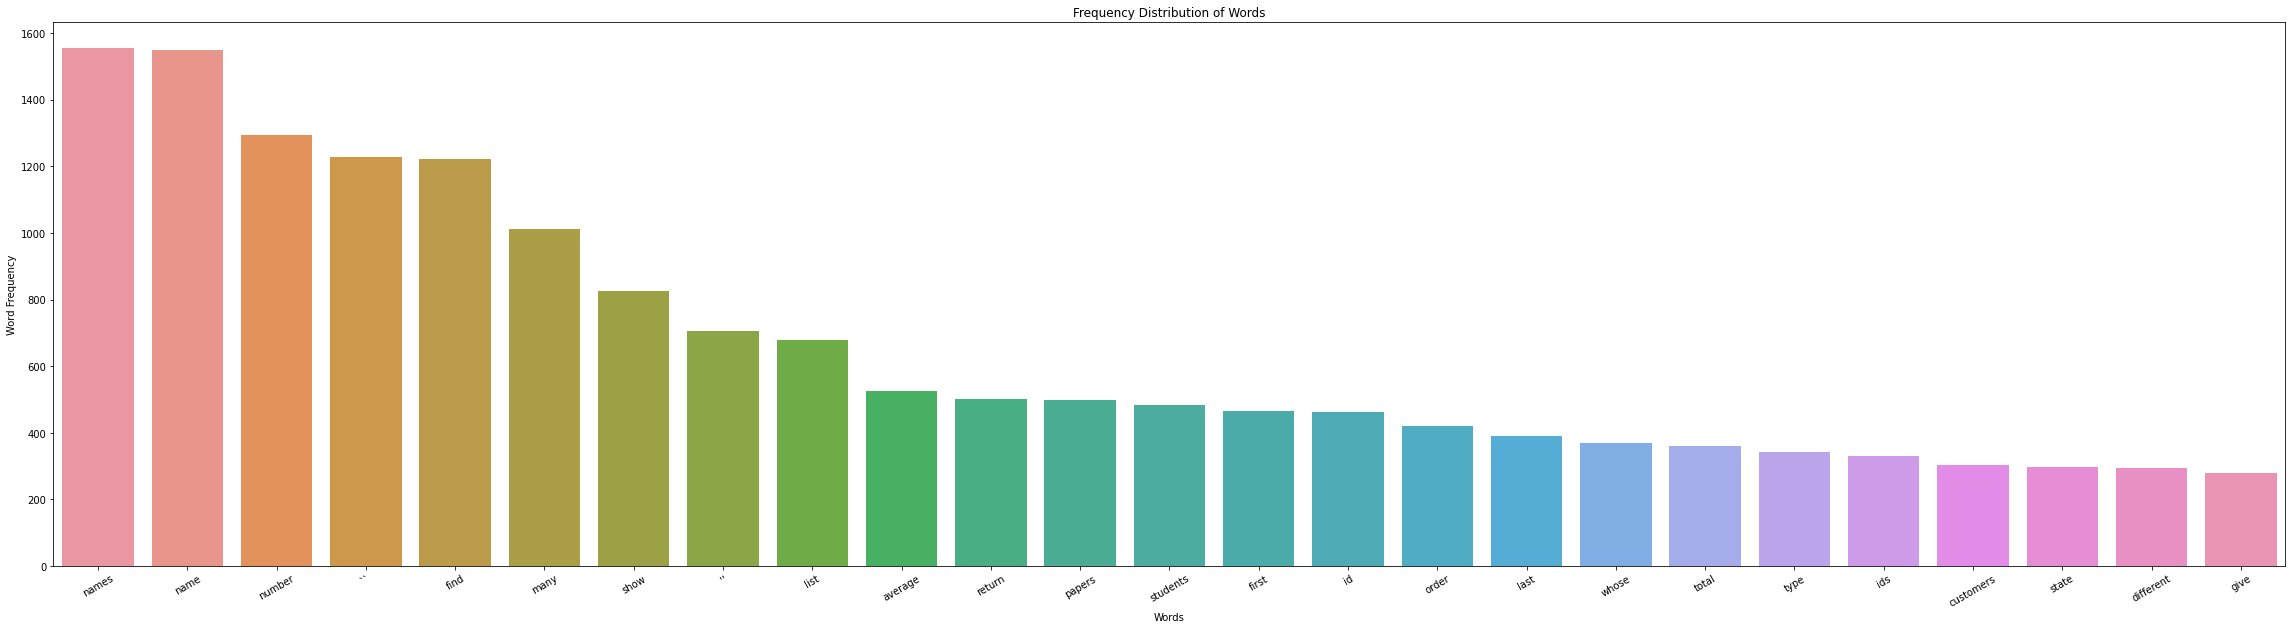

In [79]:
# Conversion to Pandas series via Python Dictionary for easier plotting
input_words_fdist = pd.Series(dict(common_25))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(40,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
plt.title('Frequency Distribution of Words')
plt.xlabel("Words")
plt.ylabel("Word Frequency")
all_plot = sns.barplot(x=input_words_fdist.index, y=input_words_fdist.values, ax=ax)
plt.xticks(rotation=30);
plt.savefig('after.pdf',dpi=1200)

##### From the above frequency distribution plot it is evident that majority of the stop words have been removed and we are getting a clean vocabulary now.
Lets perform Lemmatization now.

In [80]:
# Get Part of Speech details
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

In [81]:
def lemmatize_text(text):
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # join all
    text = "".join(text)
    return(text)

In [82]:
# Add a new column to the dataframe which will have 'question_toks' lemmatized
df_use['question_toks_clean'] = ''
df_use.head()

,question_toks,query,question_toks_no_stopwords,question_toks_clean
0,"[How, many, heads, of, the, departments, are, ...",SELECT count(*) FROM head WHERE age > 56,"[many, heads, departments, older, 56]",
1,"[List, the, name, ,, born, state, and, age, of...","SELECT name , born_state , age FROM head ORD...","[list, name, born, state, age, heads, departme...",
2,"[List, the, creation, year, ,, name, and, budg...","SELECT creation , name , budget_in_billions ...","[list, creation, year, name, budget, department]",
3,"[What, are, the, maximum, and, minimum, budget...","SELECT max(budget_in_billions) , min(budget_i...","[maximum, minimum, budget, departments]",
4,"[What, is, the, average, number, of, employees...",SELECT avg(num_employees) FROM department WHER...,"[average, number, employees, departments, whos...",


In [83]:
# Perform Lemmatization on 'question_toks_no_stopwords' column and add clean text to 'question_toks_clean' column
question_toks_clean=[]
for i in range (len(df_use)):
  input_text=df_use.loc[i, 'question_toks_no_stopwords']
  for word in input_text:
    question_toks_lemma=(lemmatize_text(word))
    question_toks_clean.append(question_toks_lemma)
  df_use.at[i,'question_toks_clean']=question_toks_clean
  question_toks_clean=[]


In [84]:
# Lets look at the data after lemmatization
df_use.head()

,question_toks,query,question_toks_no_stopwords,question_toks_clean
0,"[How, many, heads, of, the, departments, are, ...",SELECT count(*) FROM head WHERE age > 56,"[many, heads, departments, older, 56]","[many, head, department, old, 56]"
1,"[List, the, name, ,, born, state, and, age, of...","SELECT name , born_state , age FROM head ORD...","[list, name, born, state, age, heads, departme...","[list, name, born, state, age, head, departmen..."
2,"[List, the, creation, year, ,, name, and, budg...","SELECT creation , name , budget_in_billions ...","[list, creation, year, name, budget, department]","[list, creation, year, name, budget, department]"
3,"[What, are, the, maximum, and, minimum, budget...","SELECT max(budget_in_billions) , min(budget_i...","[maximum, minimum, budget, departments]","[maximum, minimum, budget, department]"
4,"[What, is, the, average, number, of, employees...",SELECT avg(num_employees) FROM department WHER...,"[average, number, employees, departments, whos...","[average, number, employee, department, whose,..."


#### Effects of Lemmatization are visible as grammar for few words has changed to their root words.

#### Now the data is ready for the next phase which will involve below tasks
  
*   Vectorisation of data
*   Implementation of Encoder & Decoder
*   Model Implementation & Validation
